#### ExpD.1.Visualising_Activations
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the Action feature vectors

In [1]:
import os
from six.moves import xrange 
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io
from sklearn import metrics
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from tf_cnnvis import *



# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=8192
nb_classes=2
saved_path='/nobackup/leopauly/S2l/'

In [3]:
print('Available GPU details:')
!nvidia-smi

Available GPU details:
Sun Feb 23 11:06:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    70W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+---------

####  Loading model 

In [4]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 
y_true = tf.placeholder(tf.float32, [None, nb_classes],name='y_true')
y_true_cls = tf.placeholder(tf.int64, [None],name='y_true_cls')

model_keras = md.C3D_ucf101_training_model_tf(summary=True)

print('Miscellenious items finished..!!',flush=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

In [5]:
out=model_keras(x_image)
y_pred = tf.nn.softmax(out)
y_pred_cls = tf.argmax(out, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


####  Feature extraction

In [6]:
## Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model 
saver = tf.train.Saver()
#saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

Model restored from file: /nobackup/leopauly/S2l/


#### Visualisation

In [7]:
## Getting 16 frames after unifrom sampling of video sample
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):
    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr) 
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [8]:
base_dir_a='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_ Only_tasks_CompvsIncomp/Push/'
sub_dir_a=os.listdir(base_dir_a)
sub_dir_a=sorted(sub_dir_a)
if '.DS_Store' in sub_dir_a:
    sub_dir_a.remove('.DS_Store')
print('\nSub directories:\n',sub_dir_a)

vis_dir='push_robo_bg_fast'
print('\nVisualising task in dir:',vis_dir)
vid=get_compress_frames_data(base_dir_a+vis_dir)
vid_=vid.reshape(-1,cluster_length,height,width,channel)


Sub directories:
 ['push_demo_0deg', 'push_demo_180deg', 'push_demo_human', 'push_robo', 'push_robo_M2', 'push_robo_M3', 'push_robo_arbview1', 'push_robo_bg_fast', 'push_robo_change_pos', 'push_robo_changetarget', 'push_robo_fast', 'push_robo_green', 'push_robo_obj2_new', 'push_robo_sideview']

Visualising task in dir: push_robo_bg_fast


In [9]:
f_v = sess.graph.get_tensor_by_name('conv1/convolution:0') 
f_v_val=np.array(sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 }))
print('Visualising feature map size:',f_v_val.shape)
f_v_val=np.reshape(f_v_val,( 16, 112, 112, 64))
print('Visualising feature map resize:',f_v_val.shape)

Visualising feature map size: (1, 1, 16, 112, 112, 64)
Visualising feature map resize: (16, 112, 112, 64)


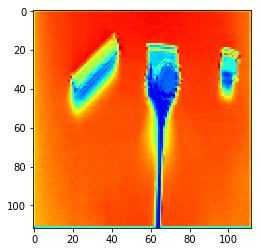

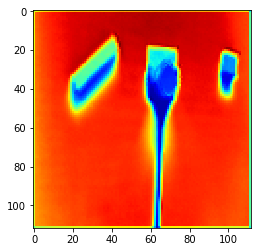

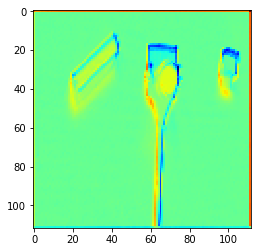

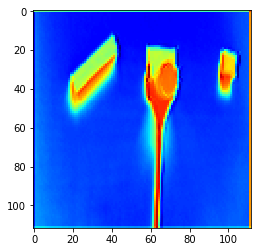

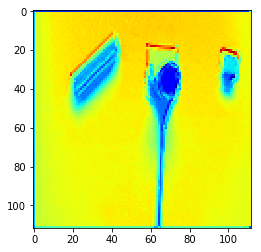

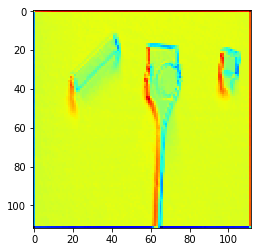

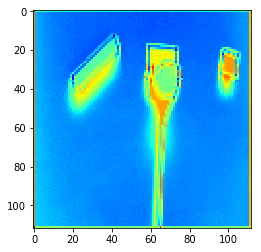

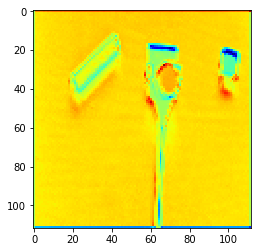

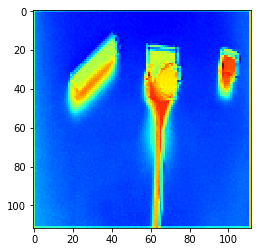

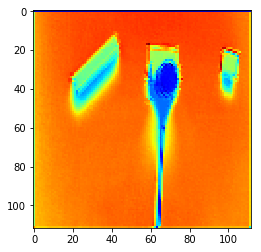

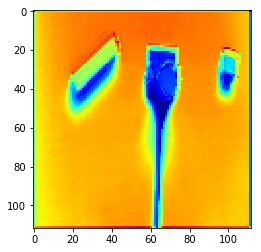

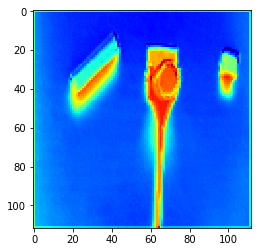

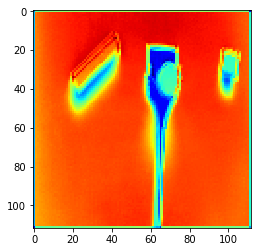

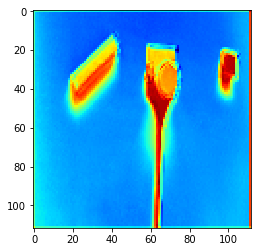

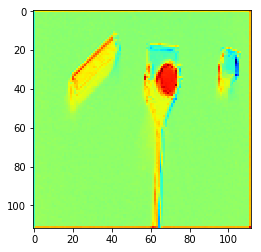

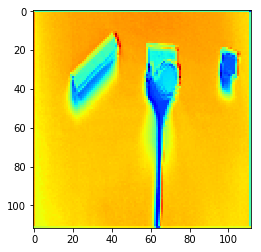

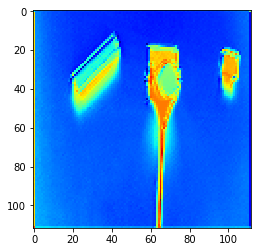

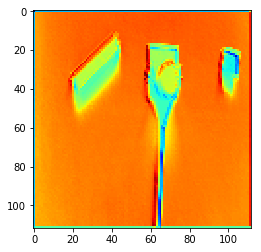

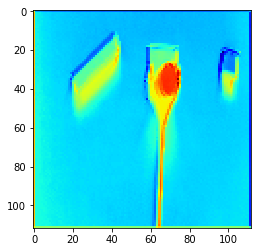

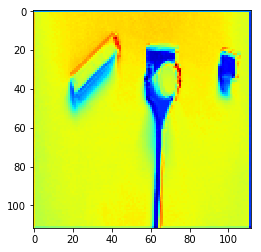

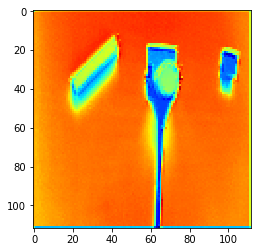

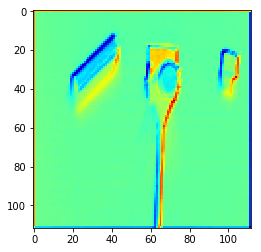

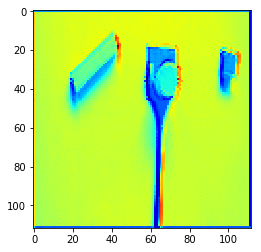

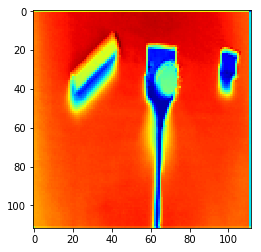

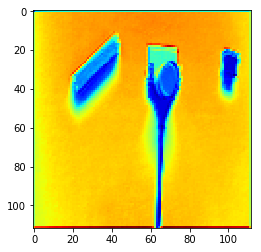

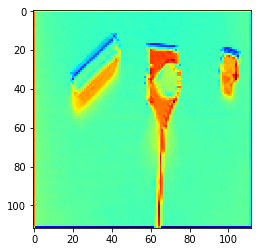

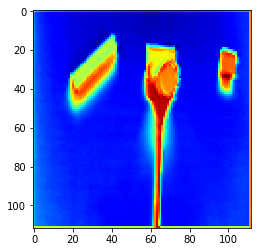

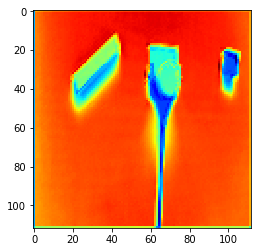

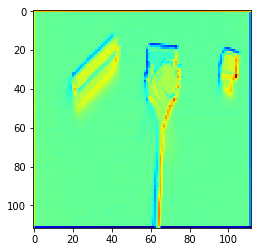

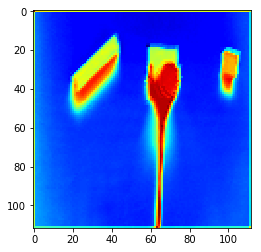

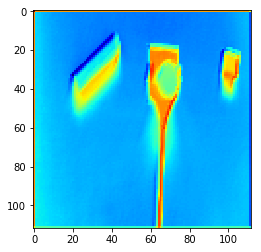

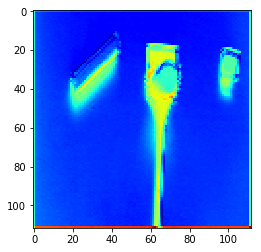

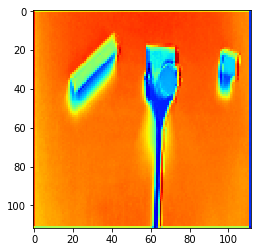

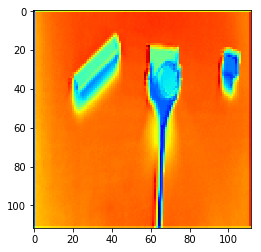

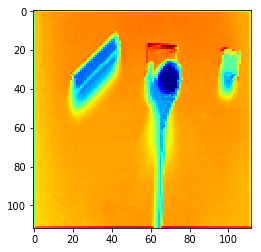

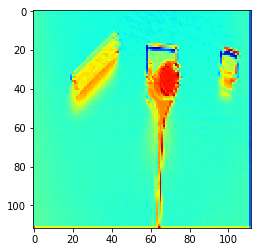

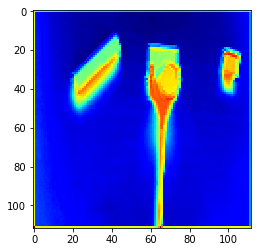

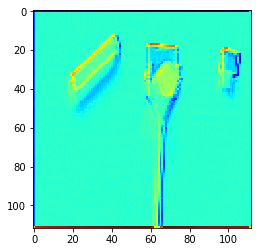

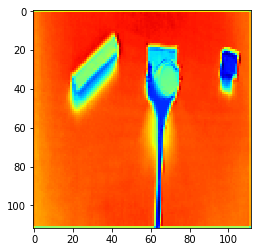

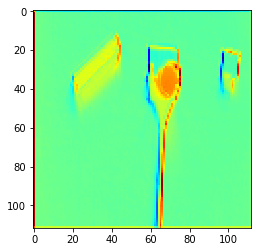

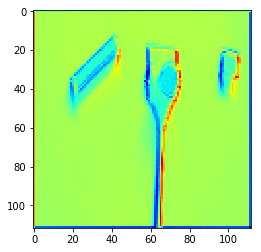

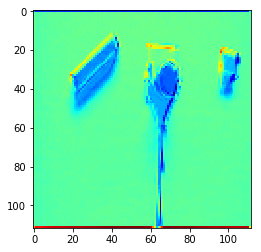

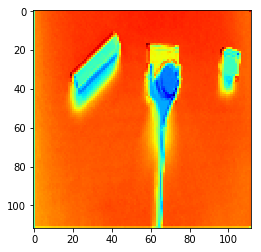

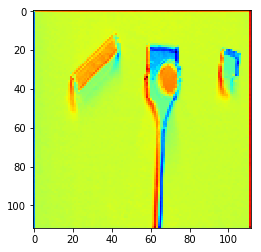

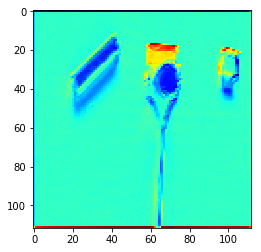

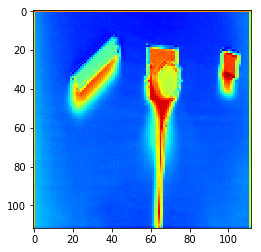

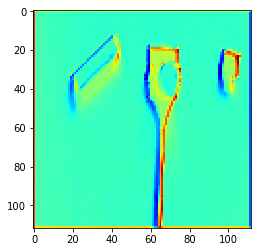

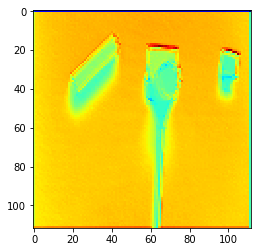

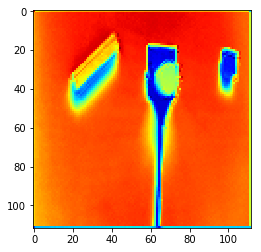

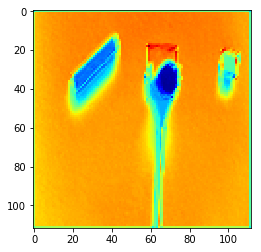

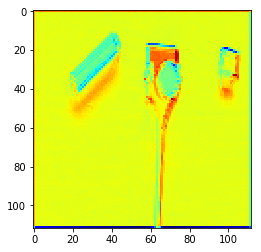

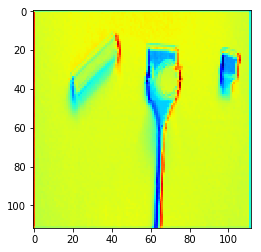

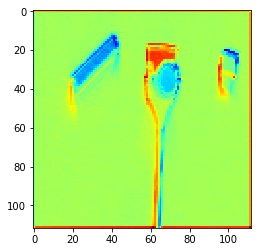

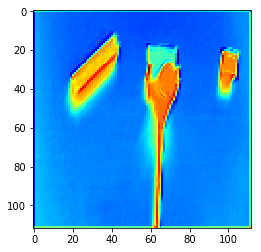

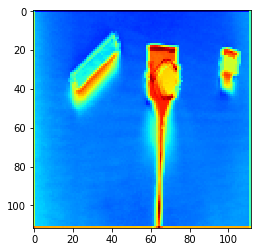

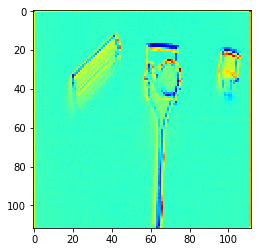

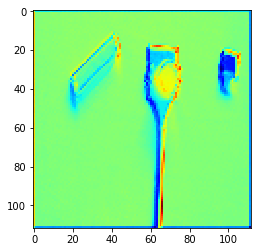

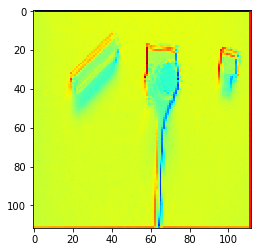

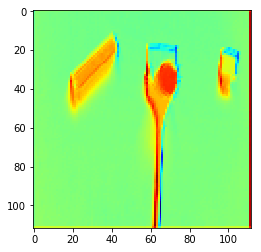

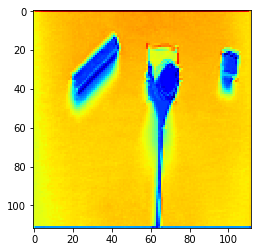

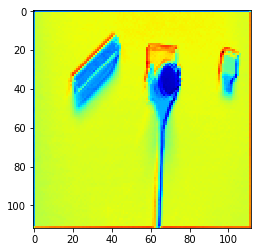

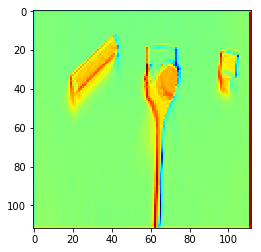

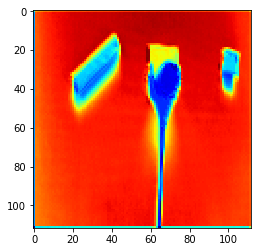

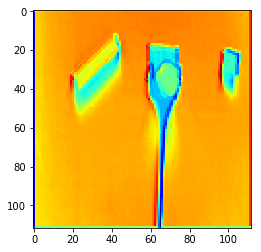

In [10]:
for i in range (64):
    plt.imshow(f_v_val[12,:,:,i],cmap='jet')
    plt.show()

In [11]:
f_v = sess.graph.get_tensor_by_name('conv1/kernel:0') 
f_v_val=np.array(sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 }))
print('Visualising feature map size:',f_v_val.shape)
f_v_val=np.reshape(f_v_val,( 3, 3, 3, 3, 64))
print('Visualising feature map resize:',f_v_val.shape)

Visualising feature map size: (1, 3, 3, 3, 3, 64)
Visualising feature map resize: (3, 3, 3, 3, 64)


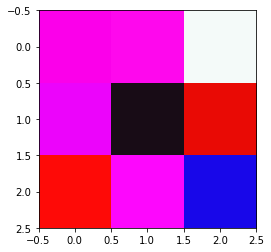

In [12]:
for i in range (1):
    plt.imshow(f_v_val[2,:,:,:,i],cmap='gray')
    plt.show()

In [13]:
for op in sess.graph.get_operations():
    print(op.name)

x
y_true
y_true_cls
conv1_input
conv1/random_uniform/shape
conv1/random_uniform/min
conv1/random_uniform/max
conv1/random_uniform/RandomUniform
conv1/random_uniform/sub
conv1/random_uniform/mul
conv1/random_uniform
conv1/kernel
conv1/kernel/Assign
conv1/kernel/read
conv1/Const
conv1/bias
conv1/bias/Assign
conv1/bias/read
conv1/convolution/Shape
conv1/convolution/dilation_rate
conv1/convolution
conv1/Reshape/shape
conv1/Reshape
conv1/add
conv1/Relu
pool1/MaxPool3D
conv2/random_uniform/shape
conv2/random_uniform/min
conv2/random_uniform/max
conv2/random_uniform/RandomUniform
conv2/random_uniform/sub
conv2/random_uniform/mul
conv2/random_uniform
conv2/kernel
conv2/kernel/Assign
conv2/kernel/read
conv2/Const
conv2/bias
conv2/bias/Assign
conv2/bias/read
conv2/convolution/Shape
conv2/convolution/dilation_rate
conv2/convolution
conv2/Reshape/shape
conv2/Reshape
conv2/add
conv2/Relu
pool2/MaxPool3D
conv3a/random_uniform/shape
conv3a/random_uniform/min
conv3a/random_uniform/max
conv3a/random_un